In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from petrobuffer.buffers import calcBuffer
from petrobuffer.conversions import get_relative_fo2

%matplotlib inline

plt.rcParams['figure.dpi'] = 200

In [32]:
# define constants in SI units
G = 6.67430e-11 # m^3 kg^-1 s^-2
kB = 1.38064852e-23 # m^2 kg s^-2 K^-1
m_H = 1.6737236e-27 # kg
avogadro = 6.02214076e23 # mol^-1
gas_const = avogadro * kB # J K^-1 mol^-1

In [33]:
# read data_dict

def find_last_iteration(folder, name=None, file_prefix="Static_Conc_"):

    if name is None:
        path = folder
    else:
        path = os.path.join(folder, name)

    i = 0
    last_i = 0
    while True:
        file_path = os.path.join(path, f"{file_prefix}{i}.dat")
        if not os.path.exists(file_path):
            break
        last_i = i
        i += 1
    return last_i

def read_data(folder, name, i):

    data_dict = {
        "inds": [],
        "PTs": [],
        "nHtots": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "n_iter": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": []
    }

    folder_path = os.path.join(folder, name)
    file_path = os.path.join(folder_path, f"Static_Conc_{i}.dat")
    
    dimension = np.genfromtxt(file_path, dtype=int,  max_rows=1, skip_header=1)
    global n_elem, n_mol, n_dust, n_layers
    n_elem = dimension[0]
    n_mol = dimension[1]
    n_dust = dimension[2]
    n_layers = dimension[3]

    header = np.loadtxt(file_path, skiprows=2, max_rows=1, dtype=str)
    global atom_names, mol_names, dust_names
    atom_names = header[3:4+n_elem]
    mol_names = header[4+n_elem:4+n_elem+n_mol]
    dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
    dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)

    d = np.loadtxt(file_path, skiprows=3)
    data_dict["data"] = d

    mu = os.path.join(folder_path, f"vertical_mix_{i}.dat")
    mu = np.loadtxt(mu, skiprows=1, usecols=3)

    data_dict["PTs"] = np.array([d[:, 2] * 1e-6, d[:, 0]]).T  # convert pressure from dyn/cm^2 to bar
    data_dict["nHtots"] = d[:, 1]
    data_dict["atoms"] = d[:, 3:4+n_elem]
    data_dict["mols"] = d[:, 4+n_elem:4+n_elem+n_mol]
    data_dict["supersats"] = d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
    data_dict["dusts"] = d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust]
    data_dict["eps_atoms"] = d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem]
    data_dict["dust_to_gas"] = d[:, 4+n_elem+n_mol+2*n_dust+n_elem]
    data_dict["dust_vol"] = d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1]
    data_dict["inds"] = i
    data_dict["mus"] = mu

    return data_dict

def convert(data_dict):

    n_tot = 10**data_dict["data"][:, 3:4+n_elem+n_mol]
    n_tot = np.sum(n_tot, axis=1)
    data_dict["ntots"] = n_tot[:, None]

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    data_dict["atoms"] = 10**data_dict["atoms"]
    data_dict["atoms"] = data_dict["atoms"] / data_dict["ntots"]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    data_dict["mols"] = 10**data_dict["mols"]
    data_dict["mols"] = data_dict["mols"] / data_dict["ntots"]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    data_dict["dusts"] = 10**(data_dict["dusts"]) * data_dict["nHtots"][:, None] / data_dict["ntots"]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict

In [34]:
# define folder and name
folder = "../output/EqCond+Remove/"
name = "Earth_P0=1e7_Tint=200_CplusO=1e-2_CtoO=0.59"

# read data
last_i = find_last_iteration(folder, name=name, file_prefix="Static_Conc_")
print(last_i)
data_dict = read_data(folder, name, last_i)
data_dict = convert(data_dict)

10


### Oxygen Fugacity

$ f\mathrm{O}_2=\left(\frac{X\mathrm{H_2O}}{X\mathrm{H_2}}\right)^2\times\exp\left(\frac{\Delta_rG}{RT}\right) $

$ \Delta_rG = 2\left(\Delta_fH_\mathrm{H_2O} + H^{\circ}_\mathrm{H_2O} - H^{\circ}_\mathrm{298.15,H_2O} - TS^{\circ}_\mathrm{H_2O}\right) - 2\left(\Delta_fH_\mathrm{H_2} + H^{\circ}_\mathrm{H_2} - H^{\circ}_\mathrm{298.15,H_2} - TS^{\circ}_\mathrm{H_2}\right) - \left(H^{\circ}_\mathrm{O_2} - H^{\circ}_\mathrm{298.15,O_2} - TS^{\circ}_\mathrm{O_2}\right) $

with Shomate Equation:

$ H^{\circ} - H^{\circ}_\mathrm{298.15} = AT + \frac{BT^2}{2}+ \frac{CT^3}{3} + \frac{DT^4}{4} - \frac{E}{T} +F - H $

$ S^{\circ} = A\ln{T} + BT + \frac{CT^2}{2} + \frac{DT^3}{3} - \frac{E}{2T^2} + G $

In [35]:
# thermochemical data and functions
# (note that \Delta_f H^\circ = H, in kJ/mol

# H2O data (valid for T in [500, 1700] K)
h2o_data = {"a": 30.09200, "b": 6.832514, "c": 6.793435, "d": -2.534480, "e": 0.082139, "f": -250.8810, "g": 223.3967, "h": -241.8264}
# H2 data (valid for T in [298, 1000] K)
h2_data  = {"a": 33.066178, "b": -11.363417, "c": 11.432816, "d": -2.772874, "e": -0.158558, "f": -9.980797, "g": 172.707974, "h": 0.0}
# O2 data (valid for T in [100, 700] K)
o2_data  = {"a": 31.32234, "b": -20.23531, "c": 57.86644, "d": -36.50624, "e": -0.007374, "f": -8.903471, "g": 246.7945, "h": 0.0}
# CO2 data (valid for T in [298, 1200] K)
co2_data = {"a": 24.99735, "b": 55.18696, "c": -33.69137, "d": 7.948387, "e": -0.136638, "f": -403.6075, "g": 228.2431, "h": -393.5224}
# CO data (valid for T in [298, 1300] K)
co_data  = {"a": 25.56759, "b": 6.096130, "c": 4.054656, "d": -2.671301, "e": 0.131021, "f": -118.0089, "g": 227.3665, "h": -110.5271}

def shomate_equation(T, const_dict):

    a = const_dict["a"]
    b = const_dict["b"]
    c = const_dict["c"]
    d = const_dict["d"]
    e = const_dict["e"]
    f = const_dict["f"]
    g = const_dict["g"]
    h = const_dict["h"]

    T = T / 1e3 # K to kK

    H_diff = a*T + b*T**2/2 + c*T**3/3 + d*T**4/4 - e/T + f - h # kJ/mol
    H_diff *= 1e3 # J/mol
    S = a*np.log(T) + b*T + c*T**2/2 + d*T**3/3 - e/(2*T**2) + g # J/mol K

    T = T * 1e3 # kK to K

    return H_diff, S

def get_fO2_water(X_h2o, X_h2, T):

    H_diff_h2o, S_h2o = shomate_equation(T, h2o_data)
    H_diff_h2, S_h2 = shomate_equation(T, h2_data)
    H_diff_o2, S_o2 = shomate_equation(T, o2_data)

    H_h2o = h2o_data["h"] * 1e3 # J/mol
    # H = 0 for H2 and O2

    dr_G = 2 * (H_h2o + H_diff_h2o - T*S_h2o) - 2 * (H_diff_h2 - T*S_h2) - (H_diff_o2 - T*S_o2)

    log_fO2 = 2 * np.log10(X_h2o / X_h2)
    log_fO2 += dr_G / (gas_const * T) / np.log(10)

    return log_fO2

def get_fO2_co2(X_co2, X_co, T):

    H_diff_co2, S_co2 = shomate_equation(T, co2_data)
    H_diff_co, S_co = shomate_equation(T, co_data)
    H_diff_o2, S_o2 = shomate_equation(T, o2_data)

    H_co2 = co2_data["h"] * 1e3 # J/mol
    # H = 0 for CO and O2

    dr_G = (H_co2 + H_diff_co2 - T*S_co2) - (H_diff_co - T*S_co) - (H_diff_o2 - T*S_o2)

    log_fO2 = np.log10(X_co2 / X_co)
    log_fO2 += dr_G / (gas_const * T) / np.log(10)

    return log_fO2

def get_Xmol(data_dict, mol_name):

    ind = np.where(mol_names == mol_name)[0][0]
    X = data_dict["mols"][:, ind]

    return X


In [36]:
P = data_dict["PTs"][:, 0]
T = data_dict["PTs"][:, 1]

x_h2o = get_Xmol(data_dict, "H2O")
x_h2 = get_Xmol(data_dict, "H2")
x_co2 = get_Xmol(data_dict, "CO2")
x_co = get_Xmol(data_dict, "CO")
x_o2 = get_Xmol(data_dict, "O2")

log_fO2_water = get_fO2_water(x_h2o, x_h2, T)
log_fO2_co2 = get_fO2_co2(x_co2, x_co, T)
log_pO2 = np.log10(x_o2 * P)

print(x_h2o[[0,9,19]] / x_h2[[0,9,19]])
print(log_fO2_water[[0,9,19]])
print(log_fO2_co2[[0,9,19]])

[1.30676953e-02 1.30676953e-02 1.18526675e-05]
[ -37.98786562  -65.91662377 -130.61752315]
[-22.38766747 -42.85636797 -88.4608174 ]


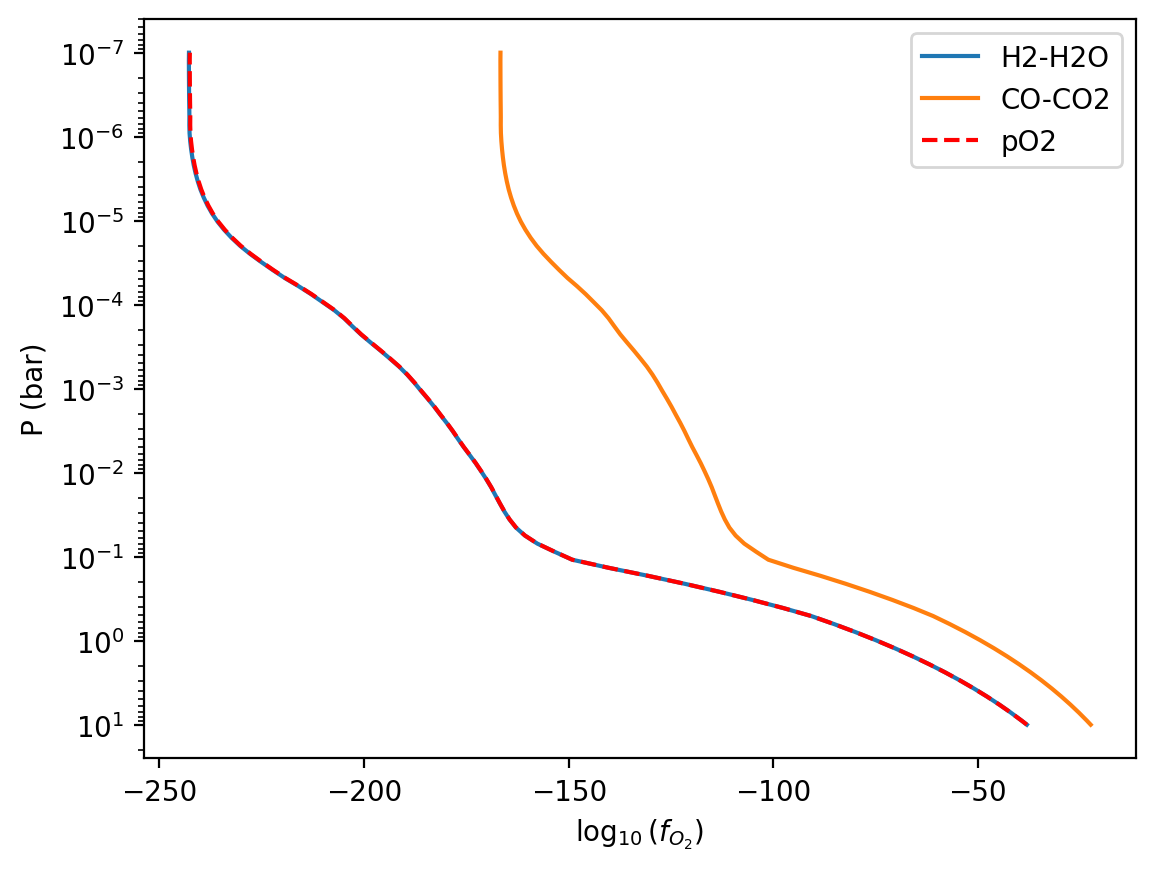

In [37]:
plt.plot(log_fO2_water, P, label="H2-H2O")
plt.plot(log_fO2_co2, P, label="CO-CO2")
plt.plot(log_pO2, P, '--', color='red', label="pO2")
plt.gca().invert_yaxis()
plt.yscale("log")

plt.xlabel(r"$\log_{10}(f_{O_2})$")
plt.ylabel("P (bar)")
plt.legend()

-37.9870080312381 646.065 10.0
-2.1414238098362333 -1.7095629599217546 -7.3839330465229445


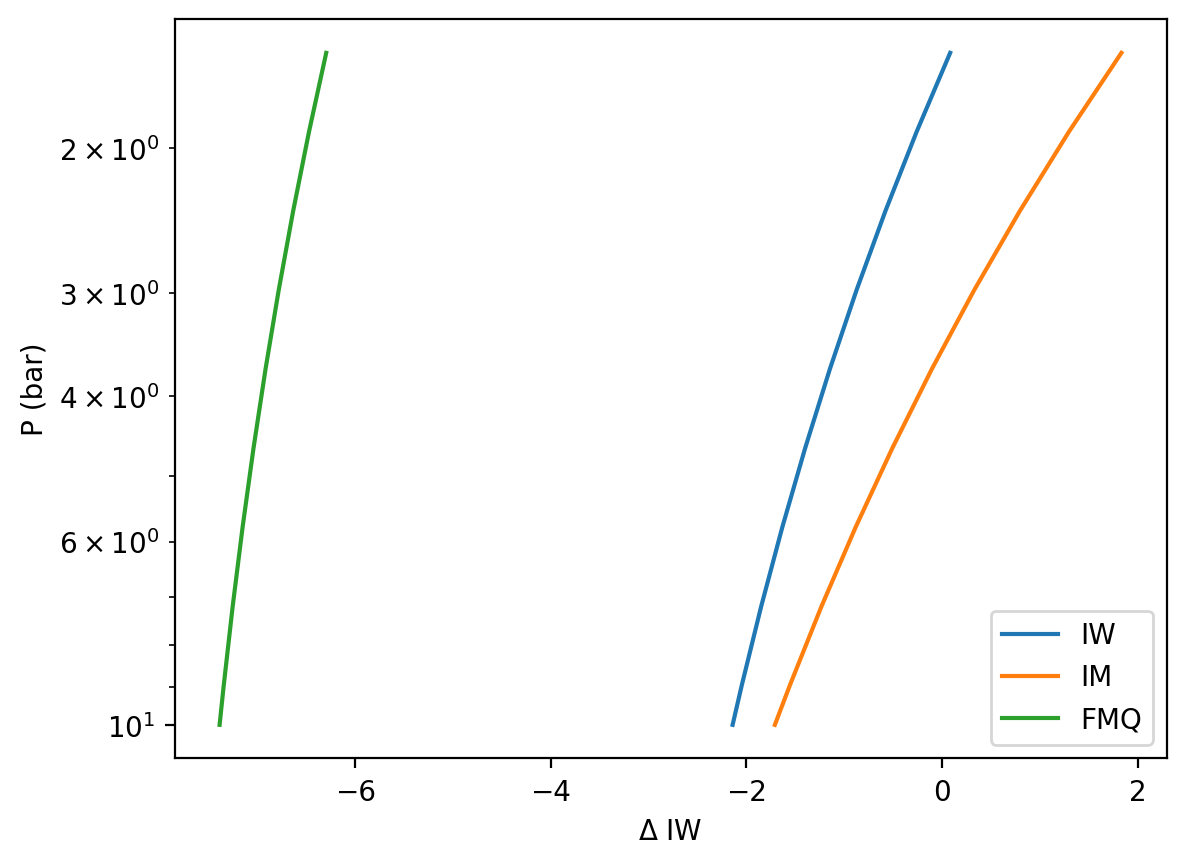

In [54]:
dIW = np.zeros_like(T)
dIM = np.zeros_like(T)
dFMQ = np.zeros_like(T)

i_test = 0
print(log_pO2[i_test], T[i_test], P[i_test])

for i in range(0, len(T)):
    dIW[i] = get_relative_fo2(log_pO2[i], 'IW', T[i], P[i])
    dIM[i] = get_relative_fo2(log_pO2[i], 'IM', T[i], P[i])
    dFMQ[i] = get_relative_fo2(log_pO2[i], 'FMQ', T[i], P[i])

print(dIW[i_test], dIM[i_test], dFMQ[i_test])

start, end, step = 0, 10, 1

plt.plot(dIW[start:end:step], P[start:end:step], label="IW")
plt.plot(dIM[start:end:step], P[start:end:step], label="IM")
plt.plot(dFMQ[start:end:step], P[start:end:step], label="FMQ")
plt.gca().invert_yaxis()
plt.yscale("log")

plt.xlabel(r"$\Delta$ IW")
plt.ylabel("P (bar)")
plt.legend();